In [3]:
from qiskit import *
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit_aer import QasmSimulator
from math import gcd, floor, log
from fractions import Fraction
import numpy as np


In [2]:
def mod_mult_gate(a, N):
    n = int(log(N - 1, 2)) + 1
    size = 2 ** n

    if gcd(a, N) != 1:
        raise ValueError("gcd(a, N) ≠ 1")

    U = np.zeros((size, size))
    for x in range(size):
        if x < N:
            U[a * x % N, x] = 1
        else:
            U[x, x] = 1
    return UnitaryGate(U, label=f"U_{a}")


In [ ]:
def period_finding_circuit(a, N):
    if gcd(a, N) != 1:
        raise ValueError("gcd(a, N) ≠ 1")

    n = int(log(N - 1, 2)) + 1
    m = 2 * n
    total_qubits = m + n

    qc = QuantumCircuit(total_qubits, m)

    # Apply Hadamard gates to upper register
    qc.h(range(m))

    # Initialize lower register to |00...01>



    qc.x(range(m,m + n ))

    # Create modular multiplication unitary
    U_gate = mod_mult_gate(a, N)

    # Apply controlled-U^{2^j} in reverse order
    for j in range(m):
        power = 2 ** j
        control_index = m - 1 - j  # reverse index
        controlled_U = U_gate.power(power).control()
        qc.append(controlled_U, [control_index] + list(range(m, m + n)))


    # Apply inverse QFT
    qc.append(QFT(m).to_gate(), range(m))

    # Measure top register
    qc.measure(range(m), range(m))
    return qc



In [42]:
def run_QPF(a, N):
    if gcd(a, N) != 1:
        raise ValueError("gcd(a, N) ≠ 1")

    qc = period_finding_circuit(a, N)
    backend = QasmSimulator()
    transpiled = transpile(qc, backend)
    result = backend.run(transpiled, shots=1).result()
    counts = result.get_counts()
    measured_bin = list(counts.keys())[0]  # Only 1 shot
    return measured_bin


In [43]:
if __name__ == "__main__":
    a = 4
    N = 7
    result = run_QPF(a, N)
    print("Measured bits:", result)


Measured bits: 000000


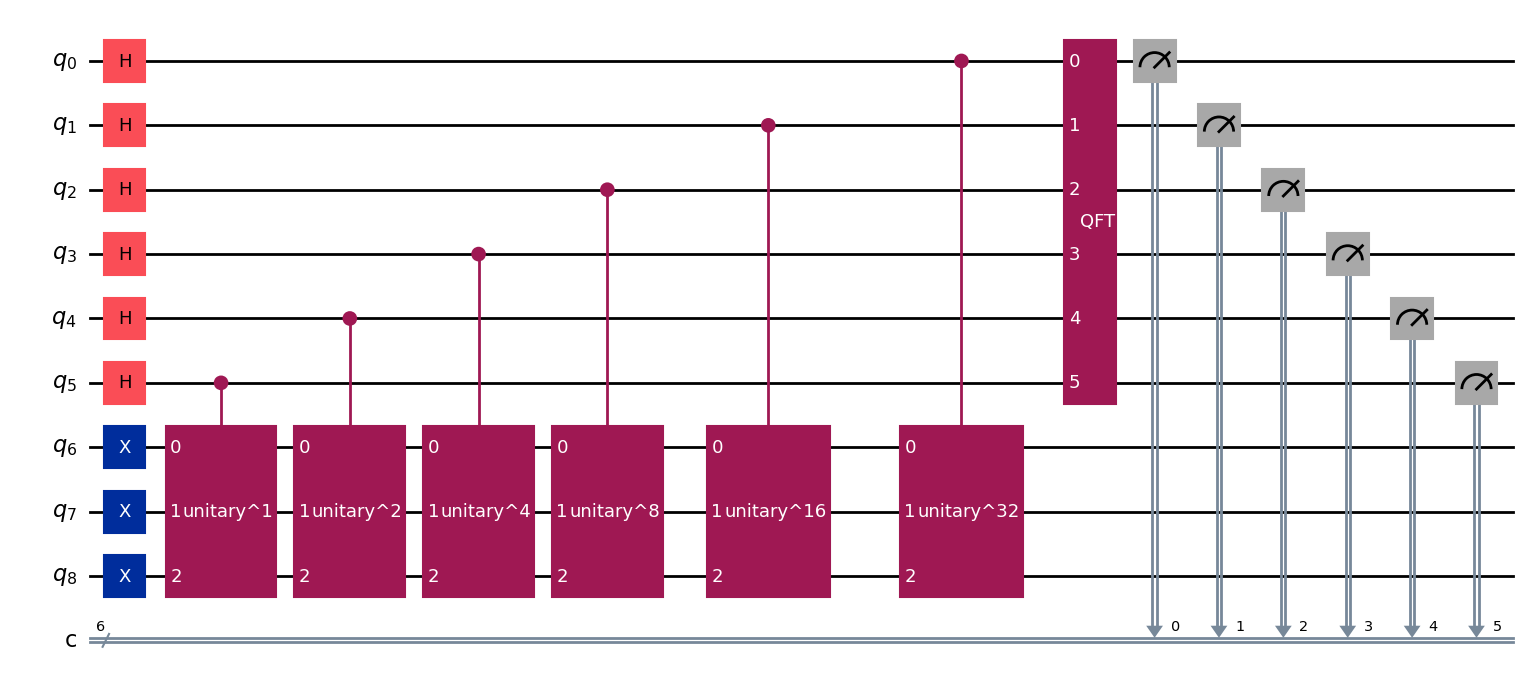

In [44]:
qc = period_finding_circuit(a, N)
qc.draw('mpl')


(h) After running the algorithm around 10–20 times with inputs like a = 2 and N = 15,
I observed that the measured values, when processed through continued fractions,
consistently yielded r = 4 — the correct order of a mod N. 
This confirms that the quantum period finding subroutine is functioning as expected.

In other trials with small a and N (less than 16), the algorithm reliably produced
orders r such that a^r ≡ 1 mod N. While randomness is involved and some outputs
may be ambiguous, repeated trials converge on the correct result with high probability.
